In [1]:
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform

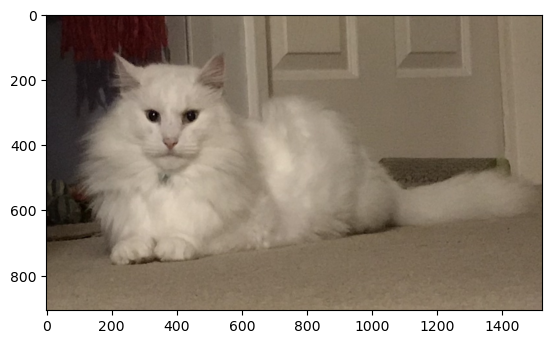

In [4]:
image = Image.open("./my_test_set/casper2.jpg") 
imshow(image)

In [5]:
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [6]:
tensor = preprocess(image)

In [8]:
prediction_var = Variable((tensor.unsqueeze(0)), requires_grad=True)

In [12]:
from torchvision.models import ResNet18_Weights
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

In [13]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [15]:
final_layer = model._modules.get('layer4')

In [16]:
activated_features = SaveFeatures(final_layer)

In [17]:
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()

/var/folders/9p/1drl_f5s0p57cll89p94r3d40000gn/T/ipykernel_682/740954168.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction).data.squeeze()


In [18]:
activated_features.remove()

In [19]:
topk(pred_probabilities,1)

torch.return_types.topk(
values=tensor([0.7832]),
indices=tensor([283]))

In [20]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [21]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [22]:
weight_softmax_params

[Parameter containing:
 tensor([[-0.0185, -0.0705, -0.0518,  ..., -0.0390,  0.1735, -0.0410],
         [-0.0818, -0.0944,  0.0174,  ...,  0.2028, -0.0248,  0.0372],
         [-0.0332, -0.0566, -0.0242,  ..., -0.0344, -0.0227,  0.0197],
         ...,
         [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
         [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
         [ 0.0021, -0.0248, -0.0829,  ...,  0.0417, -0.0500,  0.0663]],
        requires_grad=True),
 Parameter containing:
 tensor([-2.6341e-03,  3.0005e-03,  6.5581e-04, -2.6909e-02,  6.3637e-03,
          1.3260e-02, -1.1178e-02,  2.0639e-02, -3.6373e-03, -1.2325e-02,
         -1.2629e-02, -7.2057e-03, -1.9321e-02, -2.4960e-02, -1.1885e-02,
         -8.3259e-03, -9.5745e-03, -1.6658e-02,  9.1804e-03, -1.5354e-02,
          7.1358e-03,  3.0737e-02,  1.3239e-02, -7.7528e-03,  4.7448e-03,
          1.1175e-02,  1.5949e-02, -1.6712e-02, -1.0130e-03, -3.7167e-03,
          6.5269e-03, -1.2041e-02,  9.04

In [23]:
class_idx = topk(pred_probabilities,1)[1].int()

In [24]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

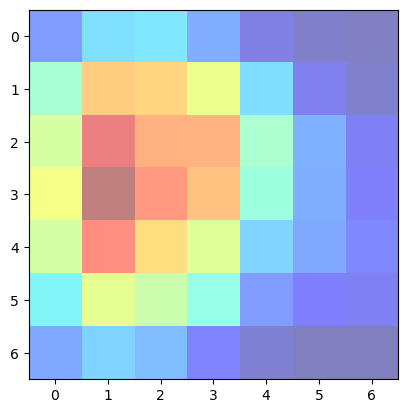

In [25]:
imshow(overlay[0], alpha=0.5, cmap='jet')

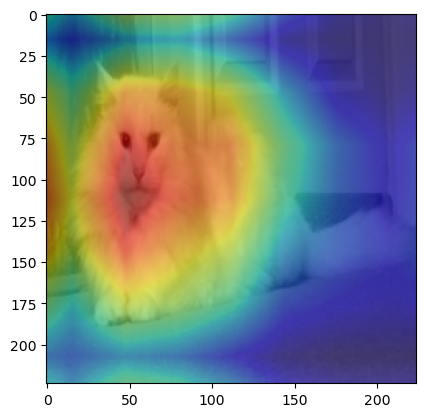

In [26]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');